## Tutorial of Causal Tracing

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (figure 1e on page 2).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)

In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [1]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/frankaging/pyvene.git

[2024-01-11 01:36:32,627] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
import torch
import pandas as pd
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    IntervenableRepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(
    name="gpt2-xl",
    cache_dir="/nlp/scr/aryaman/.cache/huggingface/hub",  # change to your local dir
)
gpt.to(device)

base = "The Space Needle is in downtown"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The Space Needle is in downtown
_Seattle             0.9763794541358948
_Bellev              0.002768289763480425
_Portland            0.0021577831357717514
,                    0.001514945994131267
_Vancouver           0.0014351347927004099
_San                 0.0013575770426541567
_Minneapolis         0.0009382699499838054
.                    0.0007443450158461928
_Tacoma              0.0006097264122217894
_Washington          0.000588554481510073


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [7]:
class NoiseIntervention(Intervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = None
        self.embed_dim = embed_dim
        self.noise_level = 0.13462981581687927

    def set_interchange_dim(self, interchange_dim):
        self.interchange_dim = interchange_dim

    def forward(self, base, source):
        # sample gaussian noise
        mean = torch.zeros_like(base[..., : self.interchange_dim])
        stdev = torch.ones_like(base[..., : self.interchange_dim]) * self.noise_level
        noise = torch.normal(mean, stdev)

        # interchange
        base[..., : self.interchange_dim] += noise

        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                0,  # layer
                "block_input",  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
        ],
        intervenable_interventions_type=NoiseIntervention,
    )
    return intervenable_config

Let's check that this reduced the probability of the output "_Seattle".

In [8]:
base = tokenizer("The Space Needle is in downtown", return_tensors="pt").to(device)
intervenable_config = corrupted_config(type(gpt))
intervenable = IntervenableModel(intervenable_config, gpt)
_, counterfactual_outputs = intervenable(
    base, [base], {"sources->base": ([[[0, 1, 2, 3]]], [[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Los                 0.038598958402872086
_San                 0.030755173414945602
_Detroit             0.025521164759993553
_St                  0.02527548372745514
_Chicago             0.02054608054459095
_Houston             0.015524095855653286
_Cleveland           0.014950713142752647
_Toronto             0.014512530528008938
_L                   0.013612194918096066
_Denver              0.013066896237432957


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [7]:
def restore_corrupted_config(model_type, layer):
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                0,  # layer
                "block_input",  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
            IntervenableRepresentationConfig(
                layer,  # layer
                "block_output",  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
        ],
        intervenable_interventions_type=[NoiseIntervention, VanillaIntervention],
        # mode='serial'
    )
    return intervenable_config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [8]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Seattle")[0]
print(token)

7312


In [9]:
data = []
for layer_i in tqdm(range(gpt.config.n_layer)):
    for pos_i in range(7):
        intervenable_config = restore_corrupted_config(type(gpt), layer_i)
        intervenable = IntervenableModel(intervenable_config, gpt)
        _, counterfactual_outputs = intervenable(
            base,
            [base, base],
            {
                "sources->base": (
                    [[[0, 1, 2, 3]], [[pos_i, pos_i, pos_i, pos_i]]],
                    [[[0, 1, 2, 3]], [[pos_i, pos_i, pos_i, pos_i]]],
                )
            },
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        prob = distrib[0][-1][token].detach().cpu().item()
        # print(layer_i, pos_i, prob)
        data.append({"layer": layer_i, "pos": pos_i, "prob": prob})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:42<00:00,  1.13it/s]


The plot below should now replicate Meng et al.

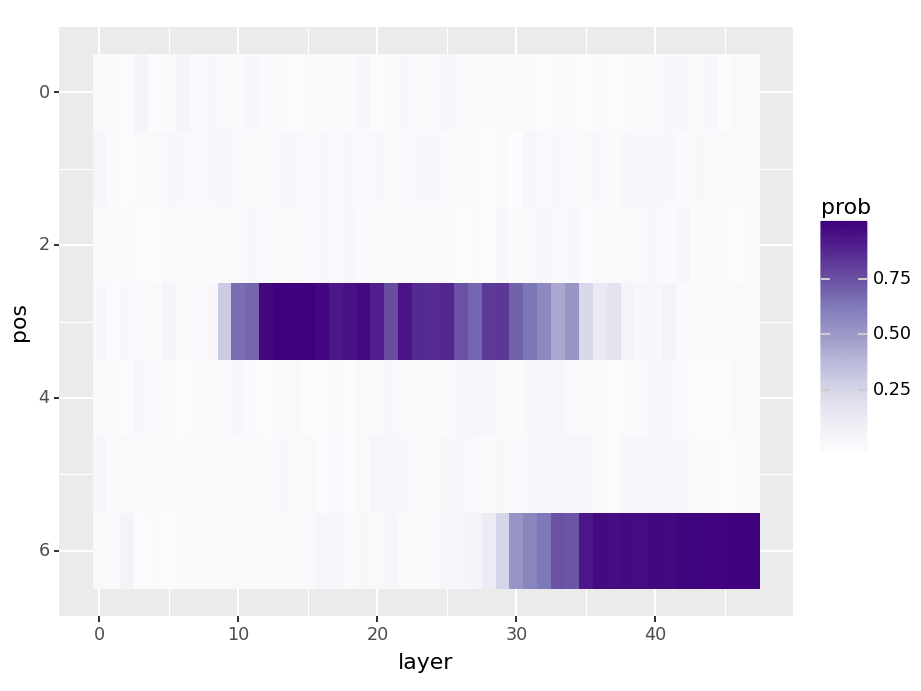

In [10]:
df = pd.DataFrame(data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["prob"] = df["prob"].astype(float)

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + scale_y_reverse()
    + geom_tile(aes(fill="prob"))
    + scale_fill_cmap("Purples")
)
print(plot)